## Set paths and rebuild the classifier

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random
import os

# ---- CONFIG ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

DATA_ROOT = Path("/kaggle/input/ham1000-segmentation-and-classification")
GROUNDTRUTH_CSV = DATA_ROOT / "GroundTruth.csv"

# 👉 Choose which images you want Grad-CAM on:
#   - full images: DATA_ROOT / "images"
#   - lesion crops: /kaggle/working/ham_lesion_crops  (from previous step)
IMAGES_DIR = Path("/kaggle/input/ham10000-segment-data/ham_lesion_crops")   # change if needed

# 👉 Folder where your classifier weights are
CLS_OUTPUT_DIR = Path("/kaggle/input/resnet34-model-testing/ham_cls_outputs_lesion_crops")  # or ham_cls_outputs
BEST_MODEL_PATH = CLS_OUTPUT_DIR / "best_cls_model.pth"

GRADCAM_OUT_DIR = Path("/kaggle/working/resnet34_gradcam_outputs")
GRADCAM_OUT_DIR.mkdir(parents=True, exist_ok=True)

FULL_IMG_DIR = DATA_ROOT / "images"  # original dermoscopic images
CROP_IMG_DIR = IMAGES_DIR            # lesion crops (already set above)

CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
num_classes = len(CLASS_NAMES)

# ---- IMAGE TRANSFORM (must match classification training) ----
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

def load_image(img_path):
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil)
    return img_pil, img_tensor.unsqueeze(0)   # (1,3,H,W)

# ---- Rebuild ResNet-34 classifier ----
resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

model = resnet.to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
model.eval()

print("Loaded classifier from:", BEST_MODEL_PATH)

Device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 162MB/s]


Loaded classifier from: /kaggle/input/resnet34-model-testing/ham_cls_outputs_lesion_crops/best_cls_model.pth


## Grad-CAM implementation

In [2]:
# ================== GRAD-CAM IMPLEMENTATION ==================

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: classification model (ResNet)
        target_layer: a conv layer or block (e.g., model.layer4)
        """
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # forward hook: save activations
        self.fwd_handle = target_layer.register_forward_hook(self._save_activation)
        # backward hook: save gradients
        self.bwd_handle = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        # output shape: (B, C, H, W)
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        # grad_output[0] shape: (B, C, H, W)
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        """
        input_tensor: (1,3,H,W) normalized
        class_idx: target class index (int). If None, uses predicted class.
        returns: heatmap (H,W), numpy in [0,1]
        """
        self.model.zero_grad()

        logits = self.model(input_tensor)   # (1, num_classes)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()

        score = logits[0, class_idx]
        score.backward()

        # activations: (1,C,H,W)
        # gradients : (1,C,H,W)
        grads = self.gradients            # (1,C,H,W)
        acts = self.activations           # (1,C,H,W)

        # global-average-pool the gradients over spatial dims
        weights = grads.mean(dim=(2, 3), keepdim=True)  # (1,C,1,1)

        # weighted sum of activations
        cam = (weights * acts).sum(dim=1, keepdim=False)  # (1,H,W) -> (H,W)
        cam = cam.squeeze(0)

        # ReLU
        cam = F.relu(cam)

        # normalize to [0,1]
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        return cam.cpu().numpy(), class_idx

    def close(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()


# create GradCAM object on last conv block (layer4)
target_layer = model.layer4   # you can also target model.layer4[-1] if you want even later
gradcam = GradCAM(model, target_layer)

## Helper: overlay heatmap on the image

In [3]:
import cv2  # OpenCV used only for color map + resize; if missing: !pip install opencv-python-headless

def overlay_cam_on_image(img_pil, cam, alpha=0.4):
    """
    img_pil: original PIL image (RGB)
    cam: (H_cam, W_cam) numpy, [0,1]
    returns: overlay as numpy uint8 image
    """
    img = np.array(img_pil).astype(np.float32) / 255.0
    h, w, _ = img.shape

    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = alpha * heatmap + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)
    return (overlay * 255).astype(np.uint8)


## Run Grad-CAM on some images

In [4]:
def run_gradcam_full_and_crop(image_id, out_dir=GRADCAM_OUT_DIR):
    full_path = FULL_IMG_DIR / f"{image_id}.jpg"
    crop_path = CROP_IMG_DIR / f"{image_id}.jpg"

    if not full_path.exists():
        print("Full image not found:", full_path)
        return
    if not crop_path.exists():
        print("Crop image not found, using full image as crop:", crop_path)
        crop_path = full_path

    # ----- FULL IMAGE -----
    full_pil = Image.open(full_path).convert("RGB")
    full_tensor = transform(full_pil).unsqueeze(0).to(DEVICE)

    cam_full, pred_idx_full = gradcam.generate(full_tensor, class_idx=None)
    pred_name_full = CLASS_NAMES[pred_idx_full]
    overlay_full = overlay_cam_on_image(full_pil, cam_full, alpha=0.5)

    # ----- CROP IMAGE -----
    crop_pil = Image.open(crop_path).convert("RGB")
    crop_tensor = transform(crop_pil).unsqueeze(0).to(DEVICE)

    cam_crop, pred_idx_crop = gradcam.generate(crop_tensor, class_idx=None)
    pred_name_crop = CLASS_NAMES[pred_idx_crop]
    overlay_crop = overlay_cam_on_image(crop_pil, cam_crop, alpha=0.5)

    # ----- PLOT 2x3 LAYOUT -----
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    # row 1: full image
    axes[0, 0].imshow(full_pil)
    axes[0, 0].set_title(f"Full Image\nID: {image_id}")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(cam_full, cmap="jet")
    axes[0, 1].set_title(f"Full Grad-CAM\nPred: {pred_name_full}")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(overlay_full)
    axes[0, 2].set_title("Full Image Overlay")
    axes[0, 2].axis("off")

    # row 2: crop
    axes[1, 0].imshow(crop_pil)
    axes[1, 0].set_title("Lesion Crop")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(cam_crop, cmap="jet")
    axes[1, 1].set_title(f"Crop Grad-CAM\nPred: {pred_name_crop}")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(overlay_crop)
    axes[1, 2].set_title("Crop Image Overlay")
    axes[1, 2].axis("off")

    plt.tight_layout()

    out_path = out_dir / f"{image_id}_full_crop_gradcam.png"
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()
    print("Saved:", out_path)

In [5]:
import pandas as pd

df = pd.read_csv(GROUNDTRUTH_CSV)
all_ids = df["image"].tolist()

for _ in range(5):  # or any number of examples
    img_id = random.choice(all_ids)
    run_gradcam_full_and_crop(img_id)

Saved: /kaggle/working/resnet34_gradcam_outputs/ISIC_0032135_full_crop_gradcam.png
Saved: /kaggle/working/resnet34_gradcam_outputs/ISIC_0026015_full_crop_gradcam.png
Saved: /kaggle/working/resnet34_gradcam_outputs/ISIC_0029917_full_crop_gradcam.png
Saved: /kaggle/working/resnet34_gradcam_outputs/ISIC_0028965_full_crop_gradcam.png
Saved: /kaggle/working/resnet34_gradcam_outputs/ISIC_0033148_full_crop_gradcam.png


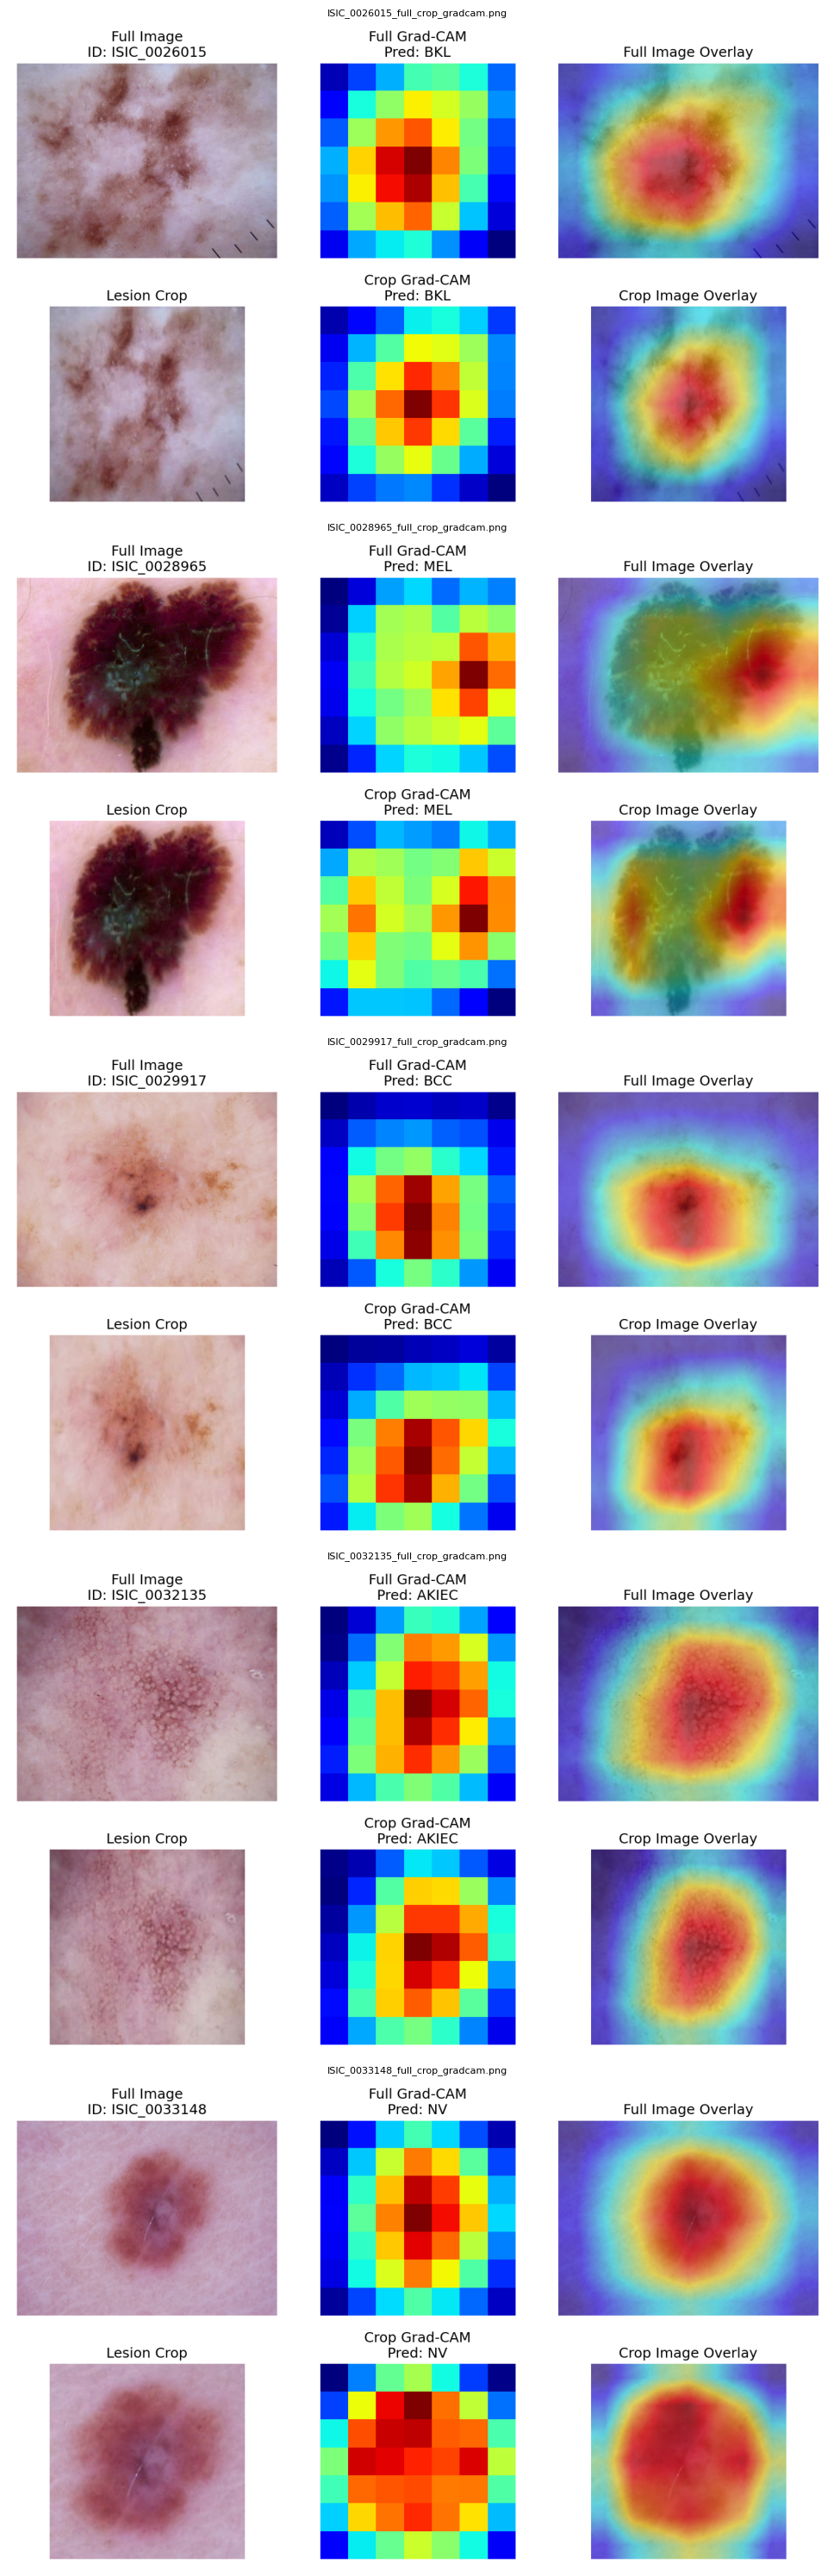

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Folder path
folder_path = '/kaggle/working/resnet34_gradcam_outputs'

# Get list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp'))]

# Sort files for consistent order
image_files.sort()

# Check if there are images
if not image_files:
    print("No image files found in the specified folder.")
else:
    # Determine grid size
    num_images = len(image_files)
    cols = 1  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate rows needed

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(200, 6 * rows))
    axes = axes.flatten()

    # Plot each image
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_file, fontsize=8)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()